# CAUSAL HMM 

This notebook contains the code snippets for the model presented in the paper "Causal AI For Interpretable Cyber Early Warning Systems"

This paper follows our previous work presented in : https://www.icsc-conference.org/2024/papers/7582.pdf

### 1. DATA PREPARATION 

First code section contains data preparation elements

In [2]:
# If necessary, install libs
#!pip install pandas matplotlib scikit-learn seaborn scipy openpyxl shap

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore') 

In [2]:
df = pd.read_csv("dataset_anonymized.csv")
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X39,X40,X41,X42,X43,X44,Y,Z1,Z2,Z3
0,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-0.427323,-0.450457,0.362949,-1.0,-1.0,0.0,1.0,0.0,0.0
1,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,-1.000000,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
2,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
3,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-1.000000,0.502083,...,0.032951,-1.000000,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0
4,0.015493,-0.034806,0.100763,0.009097,0.139021,0.391892,-1.0,0.058737,-0.446662,-0.248958,...,0.032951,0.145353,0.099085,1.725898,-1.0,-1.0,0.0,1.0,0.0,0.0


### Data description

$X_0 \dots X_{44}$ : Signals (observed)

$Y$ : Target (incident at h+1)

$Z_1 \dots Z_3$ : Latent state vector elements (from HMM)

$i$ : hours

### 2. CLASSIFIER

This code sections retrains the classifier based on signals and latent states, as shown in the first paper implementation

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  

In [4]:
# data sample
X = df.drop(['Y'],axis=1).values
y = df['Y'].astype(int).values
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

# train
clf = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

# scores
print(f'F1        : {metrics.f1_score(y_test, y_pred)}')
print(f'Accuracy  : {metrics.accuracy_score(y_test, y_pred)}')
print(f'Precision : {metrics.precision_score(y_test, y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test, y_pred)}')

F1        : 0.9241379310344827
Accuracy  : 0.9388888888888889
Precision : 0.9436619718309859
ROC-AUC   : 0.9338347781744007


### 3. L2 CAUSAL INFERENCE

Next sections contains the code to compute interventional distribution of $P(Y|do(X=x))$, i.e. fixing $X$ using Structural Causal Model (SCM) and Do Calculus. 

Do-calculus can be used to control $X$ if the SCM satisfies Back-door criterion of Front-door criterion. 

We will use Back-door criterion as given by: 

> SCM = (z->y),(z->x),(x->y)
>
> Sufficient Set = $\{Z_i\}$
>
> Condition 1. No node in $\{Z_i\}$ ($=Z$) is a descendant of $X$
>
> Condition 2. All node of $\{Z_i\}$ block back-door paths (X->Y) (fork on x<-Z->y)
>
> Therefore, we can estimate interventional distribution $P(Y|do(X=x)$ using TFF, s.t.
>
> $P(Y|do(X=x) = \sum_{i}^{}P(Y|x,Z_i)P(Z_i)$


This distribution answers the question : "Is it alert $X$ that caused $Y$ ?"

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

In [6]:
# vectorize
adf = pd.DataFrame()

# assign SCM values
x = list(df.iloc[:, 0:45].columns)
z = list(df.iloc[:, 46:49].columns)

# insert
adf['X'] = df[x].values.tolist()
adf['Z'] = df[z].values.tolist()
adf['Y'] = df['Y'].astype(int).values

# check
adf.head()

,X,Z,Y
0,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
1,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
2,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
3,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0
4,"[0.0154929577464788, -0.0348058902275769, 0.10...","[1.0, 0.0, 0.0]",0


Now, we compute  $P(Y|do(X=x) = \sum_{i}^{}P(Y|x,Z_i)P(Z_i)$

In [7]:
# setup
X = np.stack(adf['X'].values) 
Z = np.stack(adf['Z'].values) 
Y = adf['Y'].values 

# Utils for P(Y|x,z)
model = LogisticRegression(random_state=42)
model.fit(np.hstack((X, Z)), Y, )

# Utils for P(Y|do(X=x))
def compute_do_prob(x_val, df, model):
    Z = np.stack(df['Z'].values) 
    X_z_combined = np.hstack((np.repeat([x_val], len(Z), axis=0), Z))
    P_Y_given_x_Z = model.predict_proba(X_z_combined)[:, 1]
    unique_Z, counts = np.unique(Z, axis=0, return_counts=True)
    P_Z = counts / len(Z)  
    P_Y_do_x = np.sum([P_Y_given_x_Z[i] * P_Z[i] for i in range(len(P_Z))])
    return P_Y_do_x

# create identify matrix for each signal such that X(target)=x and X(non-target)=0 
signals_id = np.identity(45)
signals_id = pd.DataFrame(signals_id)
signals_id.columns = x
signals_id.index = x

In [8]:
# Compute P(Y|do(X=x))
doxl = []

for index, row in signals_id.iterrows():
    x_val = np.array(row)
    P_Y_do_x = compute_do_prob(x_val, adf, model)
    doxl.append(P_Y_do_x)

doXdf = pd.DataFrame()
doXdf['X'] = x
doXdf['doX'] = doxl
doXdf.head()

,X,doX
0,X0,0.944798
1,X1,0.900544
2,X2,0.832035
3,X3,0.566808
4,X4,0.497696


In [9]:
# compute standard-error & confidence interval .95

lci1 = []
lci2 = []

for x in list(df.columns)[:-4] : 
    se = df[[x]].std() / np.sqrt(len(df[x]))
    mu = df[[x]].mean()
    ci1 = mu - 2 * se
    ci2 = mu + 2 * se
    lci1.append(ci1[0])
    lci2.append(ci2[0])

doXdf['Ci1'] = lci1
doXdf['Ci2'] = lci2

l = []
u = []

for index, row in doXdf.iterrows():

    d = row['doX']
    low = row['doX'] + row['Ci1']
    upp = row['doX'] + row['Ci2']

    l.append(low)
    u.append(upp)

doXdf['Ci1'] = l
doXdf['Ci2'] = u
doXdf.head()

,X,doX,Ci1,Ci2
0,X0,0.944798,0.935487,0.954067
1,X1,0.900544,0.886129,0.915055
2,X2,0.832035,0.808204,0.855586
3,X3,0.566808,0.561406,0.572185
4,X4,0.497696,0.469676,0.525330


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

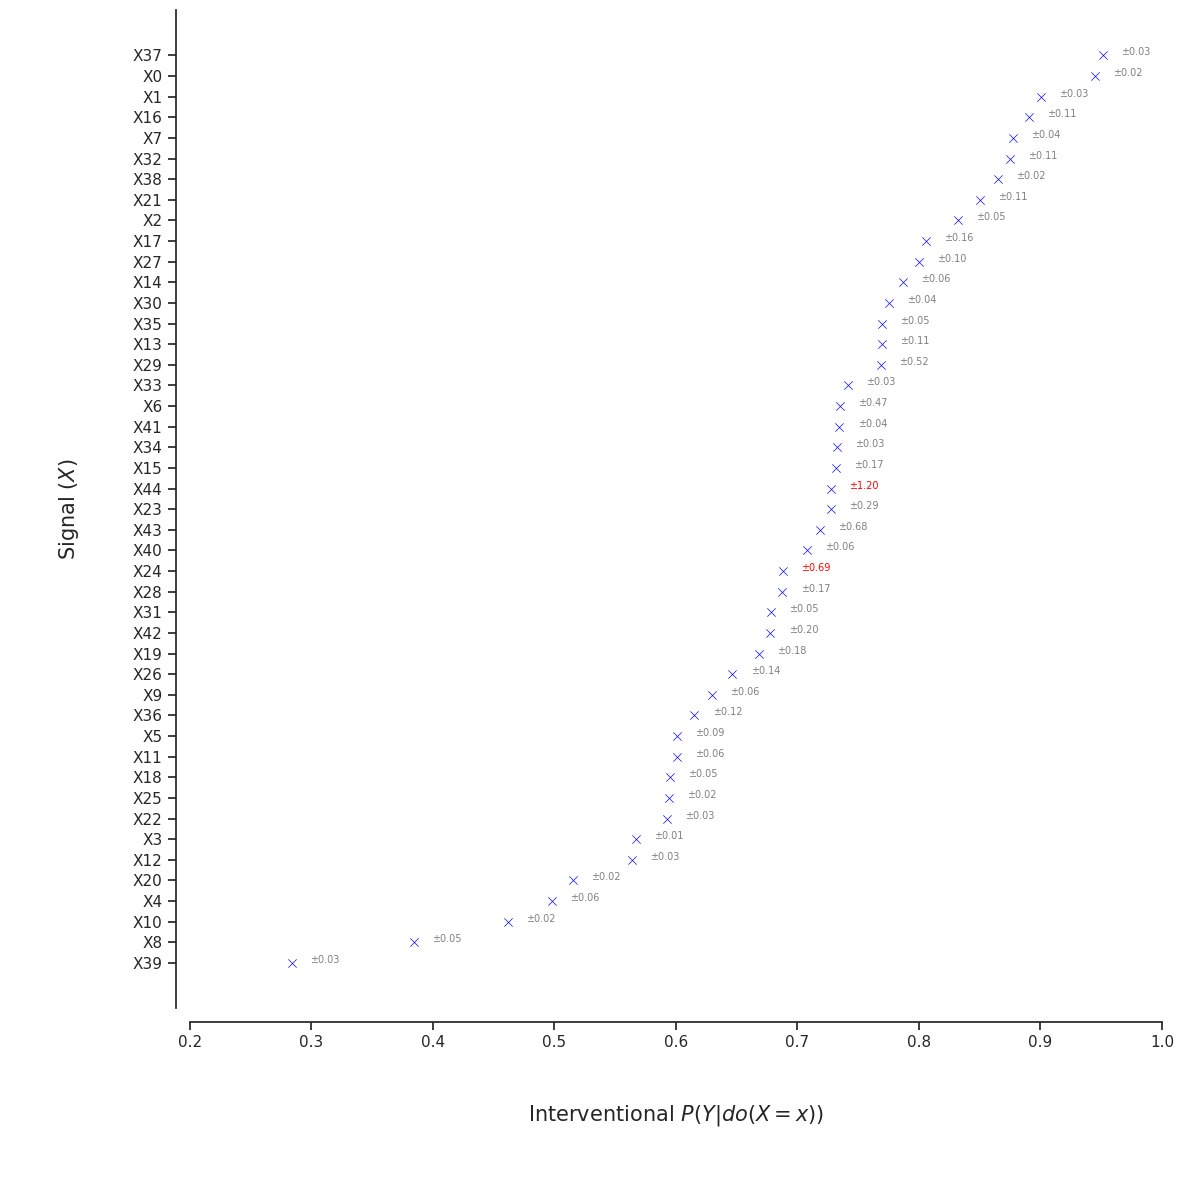

In [124]:
# Plot the DoX and CI values 
#sns.set(style="whitegrid")
plt.figure(figsize=(12, 12))

# sort for better read
sorted_df = doXdf.sort_values(by=['doX'], ascending=False)

# plot values
#g = sns.catplot(data=sorted_df, y='X', x='doX', kind='swarm', height=10, aspect=1.2, color='blue', marker='X', size=5) 
#plt.scatter(sorted_df['doX'], sorted_df['X'], marker='x', color='blue')
g = sns.scatterplot(data=sorted_df, x="doX", y="X", marker='x', alpha=1, color='blue')
#g.set_yticklabels(rotation=0, size=12)

# plot error range
for idx, row in doXdf.iterrows():
    error_value = row['Ci2'] - row['Ci1']
    #plt.errorbar(x=row['doX'], y=row['X'], xerr=[[row['doX'] - row['Ci1']], [row['Ci2'] - row['doX']]], 
    #             capsize=2, color='gray', elinewidth=.3)
    if error_value >= row['doX']*0.95:
        c='red'
    else:
        c='grey'
    plt.text(row['doX'] + 0.015, row['X'], f'±{error_value:.2f}', fontsize=7, color=c)

# setup ax labels and title

sns.set_style("ticks")
sns.despine(top=True, right=True, offset=10)
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\nInterventional $P(Y|do(X=x))$\n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0.2, 1, num=9))

#sns.despine(bottom=True, left=True)
#save plot
plt.draw()
plt.savefig('Figures/FIG1_PYDOX_TXTERR.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [12]:
from sklearn import preprocessing

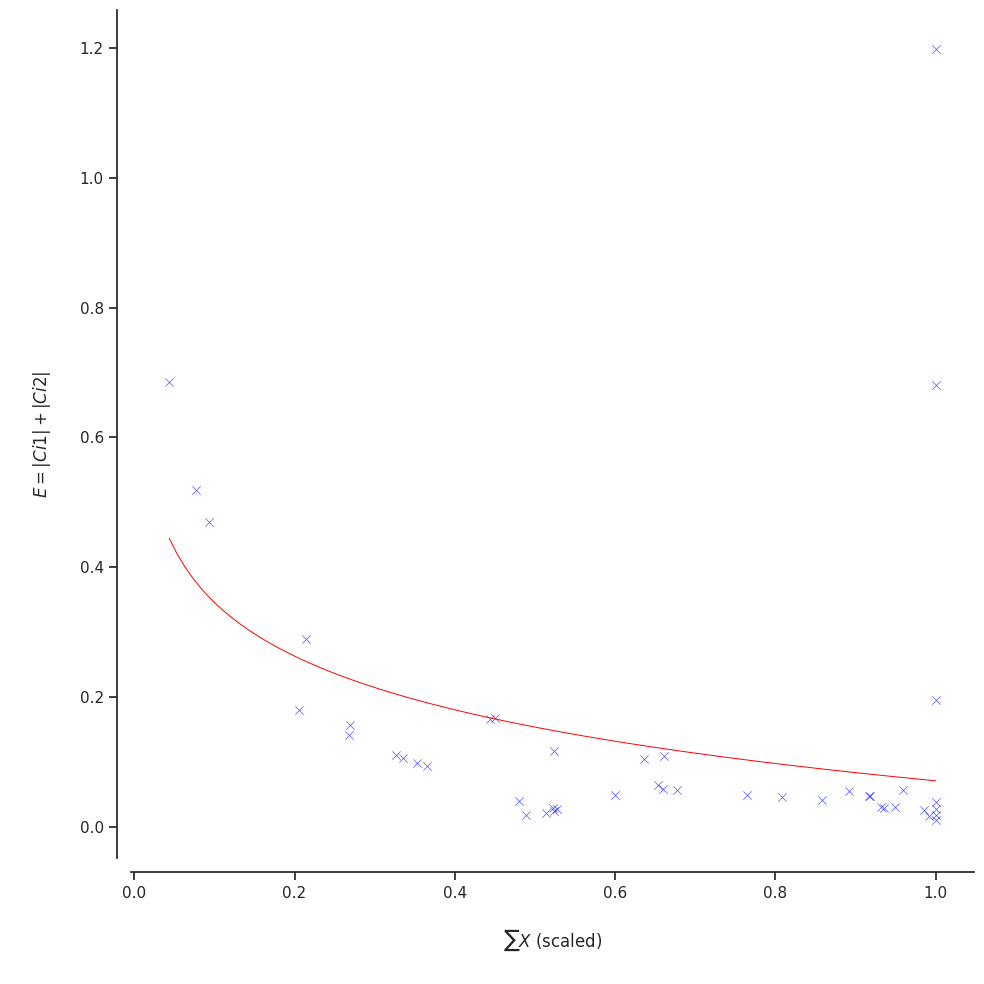

In [125]:
# same plot, but plot on one axis the span of Ci1-Ci2 and on the other the volum of this event
# Useful to better understand the really high error rates on some signals

# 0. Recover data
df2 = pd.read_csv("h_numeric_anonymized.csv")

# 1. compute sum of each column from df
v = []

for col in df2.columns[:-4]:
    v.append(df2[col].sum())

for i in range(len(v)):
    v[i] = (v[i]-min(v))/(max(v)-min(v))


# 2. compute range or error
e = []

for i in range(len(lci1)):
    e_ = abs(lci1[i])+abs(lci2[i])
    e.append(e_)

# 3. Create df
pl2 = pd.DataFrame()
pl2['X'] = doXdf['X']
pl2['V'] = v
pl2['E'] = e

# 4. plot df
plt.figure(figsize=(10,10))

# data points
g = sns.scatterplot(data=pl2, x="V", y="E", marker='x', alpha=.7, color='blue')

# log regression line
pl2['log_V'] = np.log(pl2['V'] + 1e-10)
m, b = np.polyfit(pl2['log_V'], pl2['E'], 1)
x_values = np.linspace(pl2['V'].min(), pl2['V'].max(), 100)
log_x_values = np.log(x_values + 1e-10)
y_values = m * log_x_values + b

plt.plot(x_values, y_values, color='red', linewidth=.7)

# style
sns.set_style("ticks")
sns.despine(top=True, right=True, offset=10)
g.set_xlabel('\n$\sum X$ (scaled)\n')
g.set_ylabel('\n$E = |Ci1|+|Ci2|$\n')

plt.draw()
plt.savefig('Figures/FIG2_FREQ_ERROR_PYDOX.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

### 4. L3 CAUSAL INFERENCE

## Method 1. Using TFF

Next sections contains the code to compute conterfactual distribution $P(Y_{do(X=x)} = y | X , Y)$, by using meta learners. 

Given the structural causal model, the distribution is given by : $P(Y_{do(X=1) = 1} | X = 0, Y = 0) = \frac{P(Y_{X=1}=1,X=0,Y=0)}{P(X=0,Y=0)}$

This distribution answers the question : "Would have $Y$ been different if we had $X_0$ instead of $X_1$ ?"

In [57]:
# 1. Compute P(X=0, Y=0) for each X
P_X0_Y0 = []
for x in list(df2.columns[:-4]):
    c = 0
    l = 0
    for index, row in df2.iterrows():
        if row[x] == 0 and row['Y'] == 0:
            c += 1
        if row['Y'] == 0:
            l += 1
    P_X0_Y0.append(c/l)

doXdf['P_X0_Y0'] = P_X0_Y0

# 2. Compute numerator for non 0 relative denominator
l3 = []
for index, row in doXdf.iterrows():
    if row['P_X0_Y0'] > 0 :
        i = row['doX'] * row['P_X0_Y0']
    else:
        i = 0
    l3.append(i)

doXdf['P_Y1_DX1'] = l3
doXdf.head()

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1
0,X0,0.944798,0.935487,0.954067,0.026961,0.025473
1,X1,0.900544,0.886129,0.915055,0.000000,0.000000
2,X2,0.832035,0.808204,0.855586,0.080882,0.067297
3,X3,0.566808,0.561406,0.572185,0.000000,0.000000
4,X4,0.497696,0.469676,0.525330,0.068627,0.034156


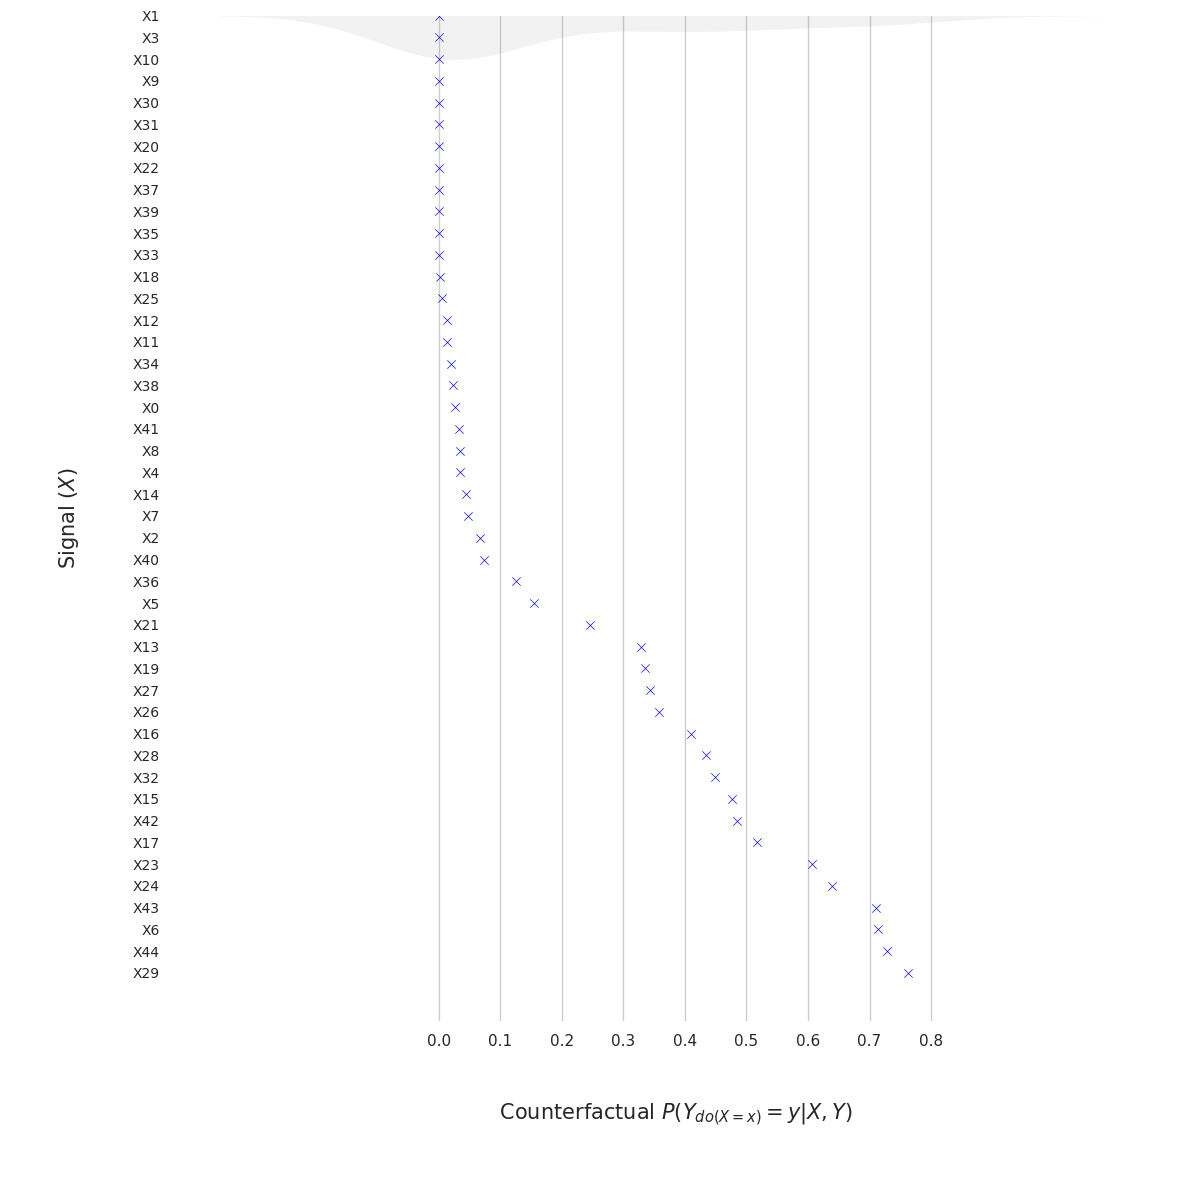

In [140]:
plt.figure(figsize=(12, 12))
plt.grid(axis='y')
#sns.set(style="whitegrid")


# sort for better read
sorted_df = doXdf.sort_values(by=['P_Y1_DX1'], ascending=True)

# plot values
sns.scatterplot(data=sorted_df, y='X', x='P_Y1_DX1', color='blue', marker='x', zorder=1) 

sns.kdeplot(data=doXdf['P_Y1_DX1'], 
            color='grey', 
            linewidth=0, 
            alpha=0.1, 
            fill=True,
            zorder=2)

# setup ax labels and title
plt.ylabel("\n\nSignal ($X$)\n\n", fontsize=15)
plt.xlabel("\n\n Counterfactual $P(Y_{do(X=x)} = y | X , Y)$ \n\n", fontsize=15)
plt.xticks(ticks=np.linspace(0, 0.8, num=9))
plt.yticks(size=10)
sns.despine(bottom=True, left=True)

#save plot
plt.draw()
plt.savefig('Figures/FIG3_PYYDOXX_COUNTERFACTUAL.jpeg', dpi=400, bbox_inches='tight')

plt.tight_layout()
plt.show()

## Method 2. Using Meta Learners

> Source : https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

### S-Learner : single model

> Train model on (X,Y,Z, T), s.t. we obtain $\hat{f}(X,Z,T) = E\{Y|X,Z,T\}$
>
> Where $Z$ represents $\langle Z_1, Z_2, Z_3\rangle$, $X$ the signals, $T$ the treatment, $Y$ the outcome
>
> When model is trained, compute:
>
> $ITE_i = \hat{f}(X_i = 1, Z_i) - \hat{f}(X_i = 0, Z_i)$
>
> Finally, compute $ATE_T = \frac{1}{N}\sum ITE_i$

In [141]:
from sklearn.neural_network import MLPClassifier

In [143]:
# Compute ATE for each signal

test = df.sample(frac=0.3, random_state=42)
train = df.loc[~df.index.isin(test.index)]

X = list(df.columns[:45])+list(df.columns[-3:]) 
y = 'Y'

# S-Learners
s_learner_rf = RandomForestClassifier(n_estimators = 100, random_state=42) 
s_learner_rf.fit(train[X], train[y])

s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
s_learner_dnn.fit(train[X], train[y])

# T-Learners

m0_rf = RandomForestClassifier(n_estimators = 100)  
m1_rf = RandomForestClassifier(n_estimators = 100)

m0_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

# ATE lists

rf_ATE_s = []
dnn_ATE_s = []
rf_ATE_t = []
dnn_ATE_t = []

for index_a, row_a in doXdf.iterrows():

    tl = []
    T =  row_a['X']

    m0_rf.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
    m1_rf.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))
    
    m0_dnn.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
    m1_dnn.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))
    
    # Switch treatments
    for index, row in df.iterrows():
        if row[T] < 0 :
            tl.append(1)
        else:
            tl.append(0)
    
    xi_0 = df.copy()
    xi_1 = df.copy()
    xi_1[T] = tl
    
    # Compute ITE
    rf_f_x0 = s_learner_rf.predict(xi_0[X])
    rf_f_x1 = s_learner_rf.predict(xi_1[X])

    dnn_f_x0 = s_learner_dnn.predict(xi_0[X])
    dnn_f_x1 = s_learner_dnn.predict(xi_1[X])
    
    rf_ITE = []
    dnn_ITE = []
    
    for i in range(len(rf_f_x1)):
        rf_ITE.append(rf_f_x1[i]-rf_f_x0[i])

    for i in range(len(dnn_f_x1)):
        dnn_ITE.append(dnn_f_x1[i]-dnn_f_x0[i])
    
    
    # Compute ATE SL
    rf_ATE = (sum(rf_ITE)/len(rf_ITE))
    rf_ATE_s.append(rf_ATE)
    dnn_ATE = (sum(dnn_ITE)/len(dnn_ITE))
    dnn_ATE_s.append(dnn_ATE)

    # Compute ATE TL
    rf_t_learner_cate_train = m1_rf.predict(df[X]) - m0_rf.predict(df[X])
    dnn_t_learner_cate_train = m1_dnn.predict(df[X]) - m0_dnn.predict(df[X])
    
    rf_ATE = sum(rf_t_learner_cate_train)/len(rf_t_learner_cate_train)
    dnn_ATE = sum(dnn_t_learner_cate_train)/len(dnn_t_learner_cate_train)

    rf_ATE_t.append(rf_ATE)
    dnn_ATE_t.append(dnn_ATE)


doXdf['SL_RF_ATE'] = rf_ATE_s   
doXdf['SL_DNN_ATE'] = dnn_ATE_s  
doXdf['TL_RF_ATE'] = rf_ATE_t   
doXdf['TL_DNN_ATE'] = dnn_ATE_t  

In [144]:
doXdf.sort_values('SL_DNN_ATE', ascending=True).head()

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1,SL_RF_ATE,SL_DNN_ATE,TL_RF_ATE,TL_DNN_ATE
9,X9,0.629634,0.601228,0.658731,0.000000,0.000000,-0.016667,-0.109722,-0.175000,-0.031944
10,X10,0.461644,0.449228,0.474142,0.000000,0.000000,-0.002778,-0.041667,0.129167,0.283333
35,X35,0.769753,0.744513,0.793070,0.000000,0.000000,-0.011111,-0.034722,-0.211111,-0.119444
20,X20,0.515310,0.507056,0.523495,0.000000,0.000000,-0.001389,-0.029167,-0.554167,-0.408333
28,X28,0.687689,0.605335,0.772820,0.632353,0.434862,-0.001389,-0.023611,-0.212500,-0.100000


In [145]:
doXdf.to_csv('Exports/ATE_SLEARNER_TLEARNER_RF_DNN.csv', index=False)

In [146]:
# Define elasticity & cumulative gain funcs
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

## S-learner

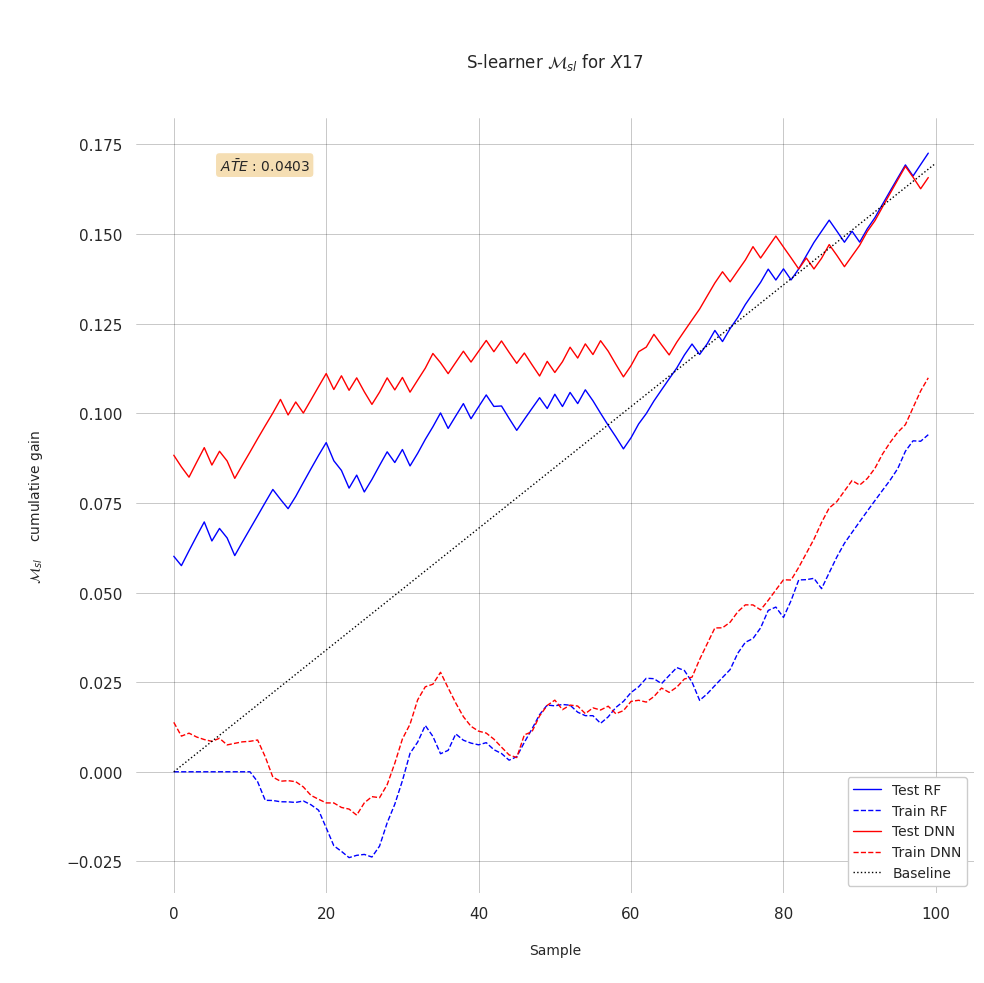

In [151]:
# Sample test/train 
signal = 'X17' # X29, X42, X28
test = df.sample(frac=0.2, random_state=42)
train = df.loc[~df.index.isin(test.index)]

# retrieve features without Y
X = list(df.columns[:45])+list(df.columns[-3:]) #-4
y = 'Y'
T = signal

# arch 1
s_learner = RandomForestClassifier(n_estimators = 100, random_state=42) 
s_learner.fit(train[X], train[y])

# arch 2
s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
s_learner_dnn.fit(train[X], train[y])

# Copy df for measure case Xi = 0 and Xi = 1
tl = []

for index, row in df.iterrows():
    # Create new column with inverse treatment as real ones
    if row[T] < 0 : # -1:
        tl.append(1)
    else:
        tl.append(0)

xi_0 = df.copy()
xi_1 = df.copy()
xi_1[T] = tl

# Compute ITE
rf_f_x0 = s_learner.predict(xi_0[X])
rf_f_x1 = s_learner.predict(xi_1[X])
rf_ITE = []

dnn_f_x0 = s_learner.predict(xi_0[X])
dnn_f_x1 = s_learner.predict(xi_1[X])
dnn_ITE = []

for i in range(len(rf_f_x1)):
    rf_ITE.append(rf_f_x1[i]-rf_f_x0[i])

for i in range(len(dnn_f_x1)):
    dnn_ITE.append(dnn_f_x1[i]-dnn_f_x0[i])

# Compute ATE for T
rf_ATE = sum(rf_ITE)/len(rf_ITE)
dnn_ATE = sum(dnn_ITE)/len(dnn_ITE)
ATE= (rf_ATE+dnn_ATE)/2     

# Estimate CATE by combining ITE models 

# with RF

rf_s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) - 
                        s_learner.predict(train[X].assign(**{T: 0})))

rf_s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

# With DNN

dnn_s_learner_cate_train = (s_learner_dnn.predict(train[X].assign(**{T: 1})) - 
                        s_learner_dnn.predict(train[X].assign(**{T: 0})))

dnn_s_learner_cate_test = test.assign(
    cate=(s_learner_dnn.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner_dnn.predict(test[X].assign(**{T: 0}))) # predict under control
)

# Cumulative Gain curves
# These plots are only useful to verify that we are not overfitting

rf_gain_curve_test = cumulative_gain(rf_s_learner_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_s_learner_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_s_learner_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_s_learner_cate_train), "cate", y="Y", t=T)

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", f'{signal}')], linewidth=1, linestyle="dotted", color="black", label="Baseline")
plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nS-learner"+r' $\mathcal{M}_{sl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{sl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)
plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.draw()
plt.box(False)
plt.savefig('Figures/FIG4_SLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

## T-Learner 

> Models learn: $\mu_0(x) = E[Y|T=0,X]$, $\mu_1(x) = E[Y|T=1,X]$
>
> Then we infer : $\hat{\gamma}(X_i) = M_1(x_i) - M_0(X_i)$

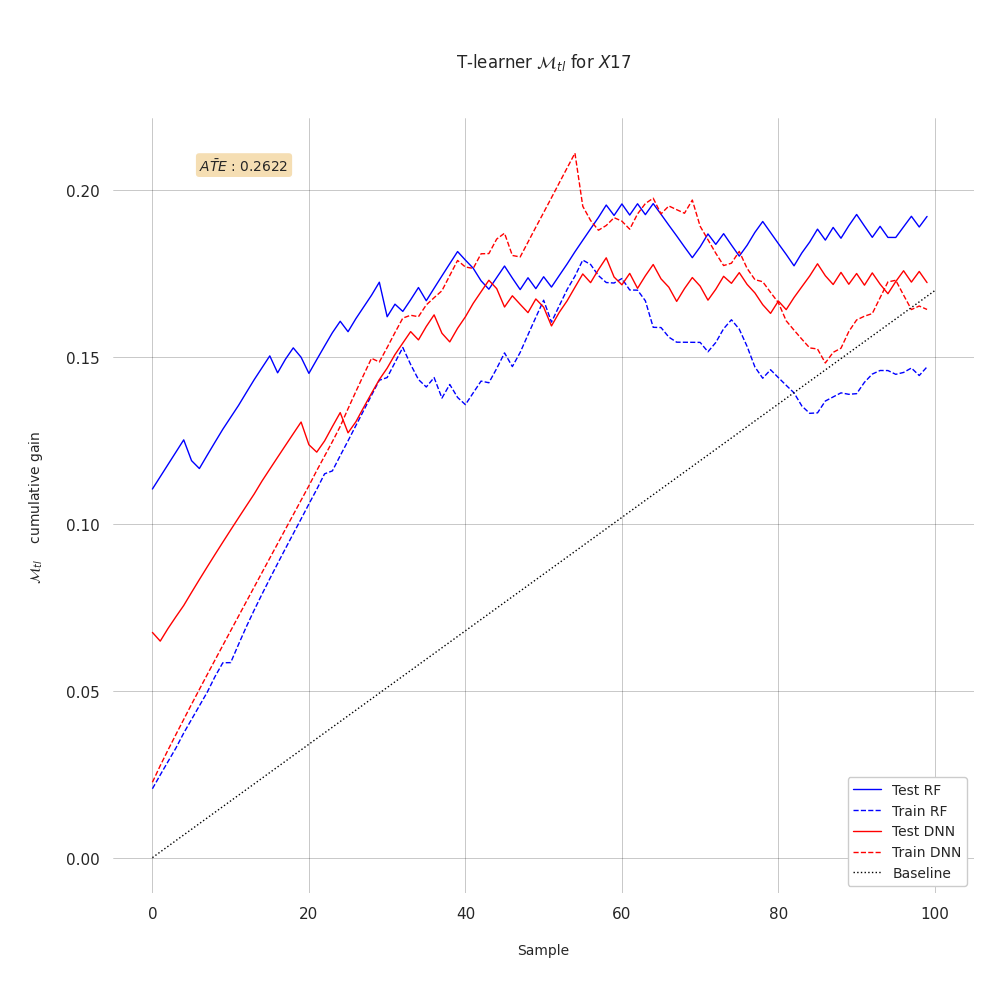

In [152]:
# setup bimodel & fit
m0_rf = RandomForestClassifier(n_estimators = 100)  
m1_rf = RandomForestClassifier(n_estimators = 100)

m0_rf.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
m1_rf.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))

m0_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

m0_dnn.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))
m1_dnn.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))

# predictions
rf_t_learner_cate_train = m1_rf.predict(train[X]) - m0_rf.predict(train[X])
rf_t_learner_cate_test = test.assign(cate=m1_rf.predict(test[X]) - m0_rf.predict(test[X]))

dnn_t_learner_cate_train = m1_dnn.predict(train[X]) - m0_dnn.predict(train[X])
dnn_t_learner_cate_test = test.assign(cate=m1_dnn.predict(test[X]) - m0_dnn.predict(test[X]))

# ATE
rf_ATE = sum(rf_t_learner_cate_train)/len(rf_t_learner_cate_train)
dnn_ATE = sum(dnn_t_learner_cate_train)/len(dnn_t_learner_cate_train)
ATE = (dnn_ATE+rf_ATE)/2

# Cumulative gain curves

rf_gain_curve_test = cumulative_gain(rf_t_learner_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_t_learner_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_t_learner_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_t_learner_cate_train), "cate", y="Y", t=T)

# plot

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", T)], linewidth=1, linestyle="dotted", color="black", label="Baseline")
plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nT-learner"+r' $\mathcal{M}_{tl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{tl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)


plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
plt.draw()
plt.box(False)

plt.savefig('Figures/FIG5_TLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

### X-Learner

Stage 1.

> $\hat{M}_0(X) = E[Y|T=0, X]$
>
> $\hat{M}_1(X) = E[Y|T=1, X]$
>

Stage 2.

> $\hat{\gamma}(X,T=0) = \hat{M}_1(X,T=0)-Y_{T=0}$
>
> $\hat{\gamma}(X,T=1) = Y_{T=1} - \hat{M}_0(X,T=1)$
>

Stage 3.

> $\hat{M}_{\gamma 0}(X) = E[\hat{\gamma}(X)|T=0]$
>
> $\hat{M}_{\gamma 1}(X) = E[\hat{\gamma}(X)|T=1]$

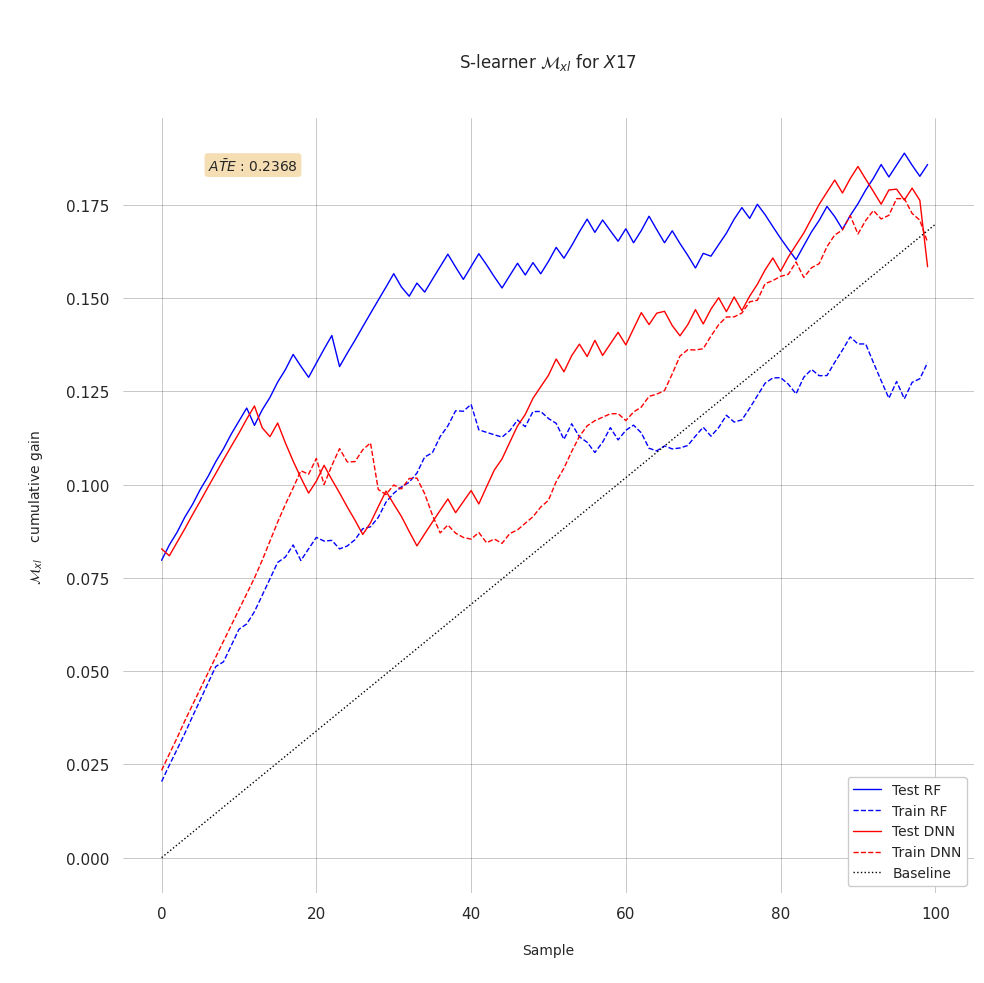

In [154]:
# Stage 1. bimodel setup & fit f(z) and g(z)

m0_rf_xl = RandomForestClassifier(n_estimators = 100)  
m1_rf_xl = RandomForestClassifier(n_estimators = 100)
m0_rf_xl.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))     # g(z)
m1_rf_xl.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))   # f(z)

m0_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m1_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
m0_dnn_xl.fit(train.query(f"{T}<0")[X], train.query(f"{T}<0")[y].astype(int))     # g(z)
m1_dnn_xl.fit(train.query(f"{T}>=0")[X], train.query(f"{T}>=0")[y].astype(int))   # f(z)

# Logistic regression as propensity score model

g = LogisticRegression(solver="lbfgs") 
g.fit(train[X], train[y].astype(int));

# Double training function util

d_train_rf = np.where(train[T]<0, m1_rf_xl.predict(train[X]) - train[y],    # D0  = f(z) - Yi
                   train[y] - m0_rf_xl.predict(train[X]))                   # D1  = Yi - G(z)

d_train_dnn = np.where(train[T]<0, m1_dnn_xl.predict(train[X]) - train[y],    # D0  = f(z) - Yi
                   train[y] - m0_dnn_xl.predict(train[X]))                   # D1  = Yi - G(z)

# Stage 2. bimodel setup & fit ITE

mx0_rf_xl = RandomForestClassifier(n_estimators = 100) # T0(z)
mx1_rf_xl = RandomForestClassifier(n_estimators = 100) # T1(z)

mx0_rf_xl.fit(train.query(f"{T}<0")[X], d_train_rf[train[T]<0]) 
mx1_rf_xl.fit(train.query(f"{T}>=0")[X], d_train_rf[train[T]>=0])

mx0_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
mx1_dnn_xl = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

mx0_dnn_xl.fit(train.query(f"{T}<0")[X], d_train_dnn[train[T]<0]) 
mx1_dnn_xl.fit(train.query(f"{T}>=0")[X], d_train_dnn[train[T]>=0])

# Stage 3. Estimate CATE

def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
rf_x_cate_train = (ps_predict(train,1)*mx0_rf_xl.predict(train[X]) +
                ps_predict(train,0)*mx1_rf_xl.predict(train[X]))

rf_x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0_rf_xl.predict(test[X]) +
                                ps_predict(test,0)*mx1_rf_xl.predict(test[X])))

dnn_x_cate_train = (ps_predict(train,1)*mx0_dnn_xl.predict(train[X]) +
                ps_predict(train,0)*mx1_dnn_xl.predict(train[X]))

dnn_x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0_dnn_xl.predict(test[X]) +
                                ps_predict(test,0)*mx1_dnn_xl.predict(test[X])))


# CATE
rf_ATE = sum(rf_x_cate_train)/len(rf_x_cate_train)
dnn_ATE = sum(dnn_x_cate_train)/len(dnn_x_cate_train)
ATE = (dnn_ATE+rf_ATE)/2

# Cumulative gains

rf_gain_curve_test = cumulative_gain(rf_x_cate_test, "cate", y="Y", t=T)
rf_gain_curve_train = cumulative_gain(train.assign(cate=rf_x_cate_train), "cate", y="Y", t=T)

dnn_gain_curve_test = cumulative_gain(dnn_x_cate_test, "cate", y="Y", t=T)
dnn_gain_curve_train = cumulative_gain(train.assign(cate=dnn_x_cate_train), "cate", y="Y", t=T)

# Plot

plt.figure(figsize=(10,10))

plt.plot(rf_gain_curve_test[:100], color="blue", label="Test RF", linewidth=1)
plt.plot(rf_gain_curve_train[:100], color="blue", label="Train RF",  linewidth=1, linestyle='--')

plt.plot(dnn_gain_curve_test[:100], color="red", label="Test DNN", linewidth=1)
plt.plot(dnn_gain_curve_train[:100], color="red", label="Train DNN",  linewidth=1, linestyle='--')

plt.plot([0, 100], [0, elast(test, "Y", T)], linewidth=1, linestyle="dotted", color="black", label="Baseline")

plt.legend(loc='lower right', fontsize=10, frameon=True, framealpha=1)
plt.title(f"\n\nS-learner"+r' $\mathcal{M}_{xl}$ for '+f"${signal}$\n\n", fontsize=12)
plt.ylabel("\n"+r'$\mathcal{M}_{xl}$'+"    cumulative gain \n", fontsize=10)
plt.xlabel("\nSample\n", fontsize=10)

textstr = r'$\bar{ATE}$ : '+f'{ATE:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=1)
plt.gca().text(0.1, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
plt.draw()
plt.box(False)

plt.savefig('Figures/FIG6_XLEARN_X17_ATE_RF_DNN.jpeg', dpi=400, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()

# PART III - EXPLAINABILITY WITH SHAP

In [155]:
import shap

### S-Learn

In [156]:
# Explain S-Learner for RF & DNN

# 1. Fit the explainer
sl_rf_explainer = shap.Explainer(s_learner.predict, test[X])
sl_dnn_explainer = shap.Explainer(s_learner_dnn.predict, test[X])

# 2. Compute SHAP values
sl_rf_shap_values = sl_rf_explainer(test[X])
sl_dnn_shap_values = sl_dnn_explainer(test[X])

PermutationExplainer explainer: 145it [00:11,  1.84it/s]                                                                      


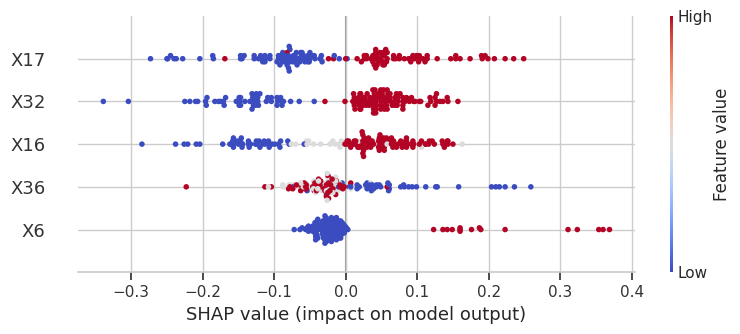

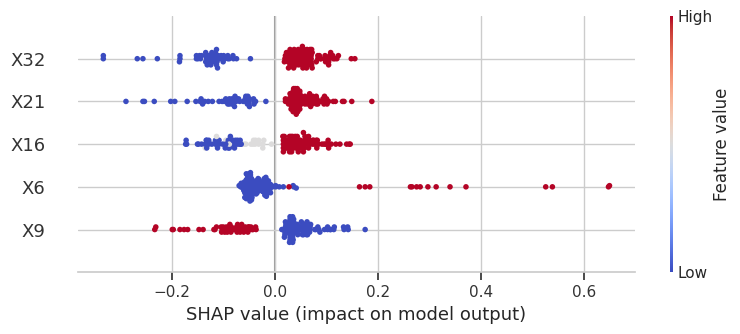

<Figure size 640x480 with 0 Axes>

In [159]:
# 3. Plot values for S-Learn RF

shap.summary_plot(sl_rf_shap_values, cmap='coolwarm', max_display=5)
plt.savefig('Figures/FIG7_SHAP_SLEARN_RF_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)
#shap.plots.bar(sl_rf_shap_values)

# 3. Plot values for S-Learn DNN

shap.summary_plot(sl_dnn_shap_values, cmap='coolwarm', max_display=5)
plt.savefig('Figures/FIG7_SHAP_SLEARN_DNN_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(sl_dnn_shap_values)

### T-Learn

In [160]:
# Explain T-Learner for RF & DNN

# 1. Fit the explainer 

# RF bimodel
tl_rf_m0_explainer = shap.Explainer(m0_rf.predict, test[X])
tl_rf_m1_explainer = shap.Explainer(m1_rf.predict, test[X])

# DNN Bimodel
tl_dnn_m0_explainer = shap.Explainer(m0_dnn.predict, test[X])
tl_dnn_m1_explainer = shap.Explainer(m1_dnn.predict, test[X])

# 2. Compute SHAP values
tl_rf_m0_shap_values = tl_rf_m0_explainer(test[X])
tl_rf_m1_shap_values = tl_rf_m1_explainer(test[X])

tl_dnn_m0_shap_values = tl_dnn_m0_explainer(test[X])
tl_dnn_m1_shap_values = tl_dnn_m1_explainer(test[X])

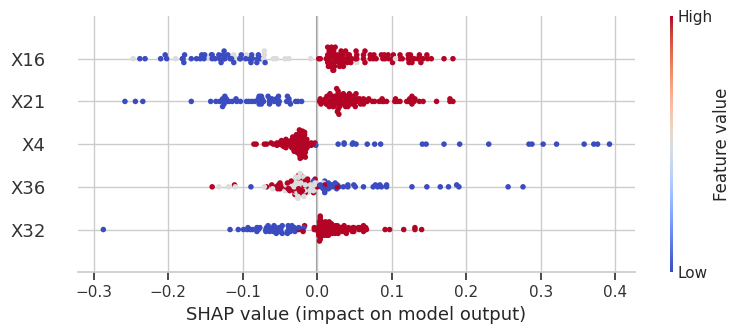

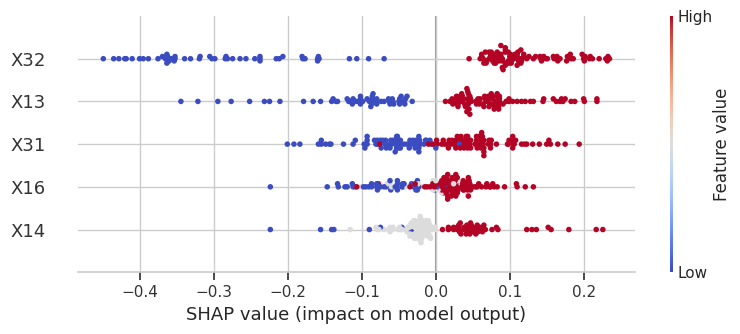

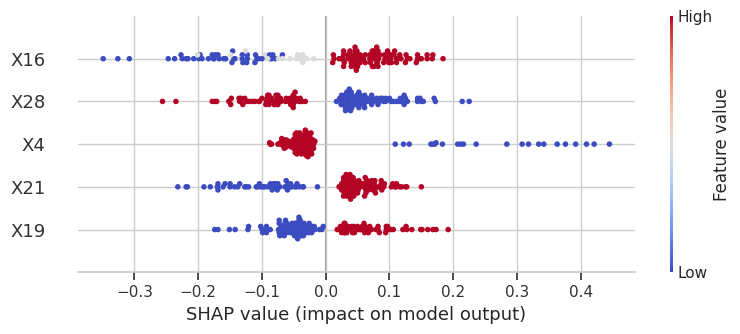

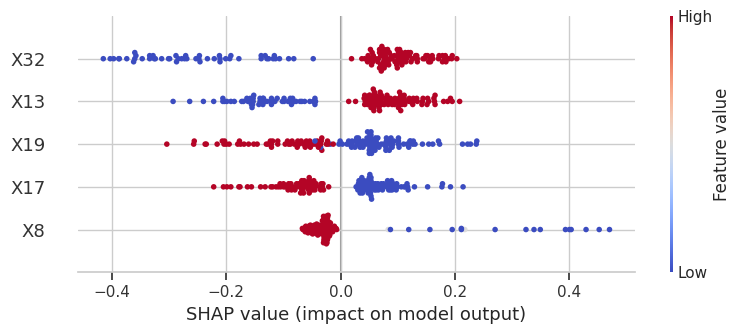

<Figure size 640x480 with 0 Axes>

In [161]:
# 3. Plot values for T-Learn RF

shap.summary_plot(tl_rf_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG9_SHAP_TLEARN_RFM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_rf_m0_shap_values)

shap.summary_plot(tl_rf_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG10_SHAP_TLEARN_RFM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_rf_m1_shap_values)

# 3. Plot values for T-Learn DNN

shap.summary_plot(tl_dnn_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG11_SHAP_TLEARN_DNNM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_dnn_m0_shap_values)

shap.summary_plot(tl_dnn_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG12_SHAP_TLEARN_DNNM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(tl_dnn_m1_shap_values)

### X-Learn

In [162]:
# Explain X-Learner for RF & DNN

# 1. Fit the explainer 

# RF Quadmodel
xl_rf_m0_explainer = shap.Explainer(m0_rf_xl.predict, test[X])
xl_rf_m1_explainer = shap.Explainer(m1_rf_xl.predict, test[X])
xl_rf_mx0_explainer = shap.Explainer(mx0_rf_xl.predict, test[X])
xl_rf_mx1_explainer = shap.Explainer(mx1_rf_xl.predict, test[X])

# DNN Quadmodel
xl_dnn_m0_explainer = shap.Explainer(m0_dnn_xl.predict, test[X])
xl_dnn_m1_explainer = shap.Explainer(m1_dnn_xl.predict, test[X])
xl_dnn_mx0_explainer = shap.Explainer(mx0_dnn_xl.predict, test[X])
xl_dnn_mx1_explainer = shap.Explainer(mx1_dnn_xl.predict, test[X])

# 2. Compute SHAP values
xl_rf_m0_shap_values = xl_rf_m0_explainer(test[X])
xl_rf_m1_shap_values = xl_rf_m1_explainer(test[X])
xl_rf_mx0_shap_values = xl_rf_mx0_explainer(test[X])
xl_rf_mx1_shap_values = xl_rf_mx1_explainer(test[X])

xl_dnn_m0_shap_values = xl_dnn_m0_explainer(test[X])
xl_dnn_m1_shap_values = xl_dnn_m1_explainer(test[X])
xl_dnn_mx0_shap_values = xl_dnn_mx0_explainer(test[X])
xl_dnn_mx1_shap_values = xl_dnn_mx1_explainer(test[X])

In [ ]:
# 3. Plot values for X-Learn RF

shap.summary_plot(xl_rf_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG13_SHAP_XLEARN_RFM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_m0_shap_values)
shap.summary_plot(xl_rf_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG14_SHAP_XLEARN_RFM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_m1_shap_values)
shap.summary_plot(xl_rf_mx0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG15_SHAP_XLEARN_RFMX0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_mx0_shap_values)
shap.summary_plot(xl_rf_mx1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG16_SHAP_XLEARN_RFMX1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_rf_mx1_shap_values)

# 3. Plot values for X-Learn DNN

shap.summary_plot(xl_dnn_m0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG17_SHAP_XLEARN_DNNM0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_m0_shap_values)
shap.summary_plot(xl_dnn_m1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG18_SHAP_XLEARN_DNNM1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_m1_shap_values)
shap.summary_plot(xl_dnn_mx0_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG19_SHAP_XLEARN_DNNMX0_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_mx0_shap_values)
shap.summary_plot(xl_dnn_mx1_shap_values, max_display=5, cmap='coolwarm')
plt.savefig('Figures/FIG20_SHAP_XLEARN_DNNMX1_TOP5.jpeg', dpi=400, bbox_inches='tight', transparent=True)

#shap.plots.bar(xl_dnn_mx1_shap_values)

# PART IV - IMPROVING ROBUSTNESS WITH CAI

The next section provides code for identification and removal of spurious features using Do-Calculus and SHAP Results. 

The logic is as following : 

> When a feature as a high doX value ($P(Y|do(X=x))$), it is unlikely to be a spurious feature
>
> The opposite is also true, since this feature is less likely to change the value of $Y$
>
> Therefor, if this feature is found with high rank in SHAP for some model, removing it / retraining the model with randomized values for this feature - will most likely increase the robustness of the model. 

In [164]:
# 1. Taking the X with greater doX value in doXdf

doXdf.sort_values('doX').head() # top values are candidates for spurrious

,X,doX,Ci1,Ci2,P_X0_Y0,P_Y1_DX1,SL_RF_ATE,SL_DNN_ATE,TL_RF_ATE,TL_DNN_ATE
39,X39,0.283800,0.270359,0.297150,0.000000,0.000000,-0.001389,-0.012500,-0.583333,-0.591667
8,X8,0.384281,0.360197,0.408069,0.088235,0.033907,-0.001389,-0.022222,0.218056,-0.043056
10,X10,0.461644,0.449228,0.474142,0.000000,0.000000,-0.002778,-0.041667,0.129167,0.283333
4,X4,0.497696,0.469676,0.525330,0.068627,0.034156,-0.004167,-0.006944,-0.493056,-0.455556
20,X20,0.515310,0.507056,0.523495,0.000000,0.000000,-0.001389,-0.029167,-0.554167,-0.408333


In [165]:
# Sample test/train 
signal = 'X17' # X29, X42, X28
test = df.sample(frac=0.2, random_state=42)
train = df.loc[~df.index.isin(test.index)]

# retrieve features without Y
X = list(df.columns[:45])+list(df.columns[-3:]) #-4
y = 'Y'
T = signal

# arch 2
vanilla_s_learner_dnn = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)
vanilla_s_learner_dnn.fit(train[X], train[y])

MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42)

In [166]:
# 2. Retrieve values of SHAP for models

sl_dnn_explainer = shap.Explainer(vanilla_s_learner_dnn.predict, test[X])
sl_dnn_shap_values = sl_dnn_explainer(test[X])

In [167]:
# 3. Compute average rank of each feature between (inverted) do(X=x) and SHAP

shap_v = np.abs(sl_dnn_shap_values.values).mean(axis=0)
shap_v = shap_v[:45]
n = test[X].columns
n = n[:45]

rdf = pd.DataFrame({'Feature': n, 'SHAP': shap_v})
rdf.head()

,Feature,SHAP
0,X0,0.005847
1,X1,0.008743
2,X2,0.012035
3,X3,0.000472
4,X4,0.031632


In [168]:
# Top N values returned are the candidates

rdf['doX'] = doXdf['doX']
lm = []

for index, row in rdf.iterrows():
    shap_r = row['SHAP']
    doX = 1-row['doX'] # we look for low DOX and high SHAP 
    mean = (shap_r+doX)/2
    lm.append(mean)

rdf['Mean']=lm
rdf.sort_values(by='Mean', ascending=True).head()

,Feature,SHAP,doX,Mean
0,X0,0.005847,0.944798,0.030524
37,X37,0.041167,0.951743,0.044712
1,X1,0.008743,0.900544,0.054100
38,X38,0.001889,0.865125,0.068382
7,X7,0.017271,0.877675,0.069798


In [173]:
rdf.to_csv('Exports/VANILLA_MLP_SPURIOUS_CANDIDATES.csv', index=False)

In [170]:
import random
from pandas.testing import assert_frame_equal

In [171]:
# Suffle for spur_candidates

rdf = rdf.sort_values(by='Mean', ascending=True)
rdf.reset_index(inplace=True, drop=True)

spur_candidate = []

for index, row in rdf.iterrows():
    if index < 5: # 5
        spur_candidate.append(row['Feature'])
        
print(f'\n[i] Spurious Candidates :      {spur_candidate}')

# Shuffle 
sdf = df.copy()

for f in spur_candidate:
    tdf = list(sdf[f])
    i = 1
    while i < 10000: # probably to much
        random.shuffle(tdf)
        i+=1
    sdf[f] = tdf

# Check false - we randomized effectively
if df.equals(sdf) == False:
    print(f'[+] Finished!\n')


[i] Spurious Candidates :      ['X0', 'X37', 'X1', 'X38', 'X7']
[+] Finished!



In [172]:
# Before shuffle, train DNN on regular (OOD) data

X_biased = df.drop(['Y'],axis=1).values # drop T_xxx 
y_biased = df['Y'].astype(int).values

X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)

def_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
def_mlp.fit(X_train_biased, y_train_biased)

# After Shuffle, train same DNN on shuffled data

X_shuf = sdf.drop(['Y'],axis=1).values 
y_shuf = sdf['Y'].astype(int).values
X_train_shuf,X_test_shuf,y_train_shuf,y_test_shuf = train_test_split(X_shuf,y_shuf,random_state=0)

shuf_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
shuf_mlp.fit(X_train_shuf, y_train_shuf)

shuf_y_pred = shuf_mlp.predict(X_test_shuf)
def_y_pred = def_mlp.predict(X_test_shuf)


# check perf
print(f'\n====== CAUSAL MLP ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf, shuf_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf, shuf_y_pred)}')

print(f'\n====== VANILLA MLP ======\n')
print(f'F1        : {metrics.f1_score(y_test_shuf, def_y_pred)}')
print(f'ROC-AUC   : {metrics.roc_auc_score(y_test_shuf, def_y_pred)}')


====== CAUSAL MLP ======

F1        : 0.868421052631579
ROC-AUC   : 0.8893421723610403

====== VANILLA MLP ======

F1        : 0.8456375838926175
ROC-AUC   : 0.86907190209077


In [176]:
v_ood_rf_df = pd.DataFrame()
v_ood_rf_df['metric'] = ['F1', 'ROC AUC']
v_ood_rf_df['Vanilla MLP'] = [metrics.f1_score(y_test_shuf, def_y_pred), metrics.roc_auc_score(y_test_shuf, def_y_pred)]
v_ood_rf_df['Causal MLP'] = [metrics.f1_score(y_test_shuf, shuf_y_pred), metrics.roc_auc_score(y_test_shuf, shuf_y_pred)]
v_ood_rf_df.to_csv('Exports/VANILLA_OOD_MLP_BENCHMARK.csv', index=False)

## Shuffle top spurious candidates

In [182]:
# Plot metrics for models trained on 1 to 10 suffled columns

# Suffle for spur_candidates

spur_candidate = []
for index, row in rdf.iterrows():
    if index < 20: 
        spur_candidate.append(row['Feature'])        
print(f'Spurious Candidates : {spur_candidate}')

# Dict for dfs & copy original

new_dfs = {}
odf = df.copy()

# Iterate on candidates func

def iterative_shuffle(candidates, dataframe):
    
    for i in range(len(candidates)):
    
        df_copy = dataframe.copy()
        
        for j in range(len(candidates[:i+1])):
        
            name_j = candidates[j]
            values_j = list(dataframe[name_j])
            count = 1
            
            while count < 100:
                random.shuffle(values_j)
                count += 1

            df_copy[name_j] = values_j

        new_dfs[f'copy_{i + 1}'] = df_copy 
    print('Done!')
    
# Iterate on candidates

iterative_shuffle(spur_candidate, odf)

Spurious Candidates : ['X0', 'X37', 'X1', 'X38', 'X7', 'X2', 'X16', 'X32', 'X21', 'X27', 'X30', 'X35', 'X14', 'X17', 'X29', 'X34', 'X33', 'X41', 'X13', 'X15']
Done!


In [183]:
# hold values

list_f1_ood = []
list_auc_ood = []

list_f1_biased = []
list_auc_biased = []

# Train model on biased dataset (original)

X_biased = df.drop(['Y', df.iloc[:,-1:].columns[0]],axis=1).values 
y_biased = df['Y'].astype(int).values

X_train_biased,X_test_biased,y_train_biased,y_test_biased = train_test_split(X_biased,y_biased,random_state=0)

def_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
def_mlp.fit(X_train_biased, y_train_biased)

# Train a debiased model on each dataset from new_dfs

for name, shuffled_df in new_dfs.items():

    #print(f'=======================')
    print(f"Training OOD DNN on {name}")
    
    X_shuf = shuffled_df.drop(['Y', shuffled_df.iloc[:,-1:].columns[0]],axis=1).values 
    y_shuf = shuffled_df['Y'].astype(int).values
    
    X_train_shuf,X_test_shuf,y_train_shuf,y_test_shuf = train_test_split(X_shuf,y_shuf,random_state=0)

    shuf_mlp = MLPClassifier(solver='adam', activation='relu',alpha=1e-2,hidden_layer_sizes=(64,32,32,16,8), random_state=4,max_iter=100, learning_rate_init=.01)
    shuf_mlp.fit(X_train_shuf, y_train_shuf)

    print(f"Testing OOD DNN on {name}")
    
    shuf_y_pred = shuf_mlp.predict(X_test_shuf)
    list_f1_ood.append(metrics.f1_score(y_test_shuf, shuf_y_pred))
    list_auc_ood.append(metrics.roc_auc_score(y_test_shuf, shuf_y_pred))
        
    print(f"Testing Biased DNN on {name}")
    
    def_y_pred = def_mlp.predict(X_test_shuf)
    list_f1_biased.append(metrics.f1_score(y_test_shuf, def_y_pred))
    list_auc_biased.append(metrics.roc_auc_score(y_test_shuf, def_y_pred))

Training OOD DNN on copy_1
Testing OOD DNN on copy_1
Testing Biased DNN on copy_1
Training OOD DNN on copy_2
Testing OOD DNN on copy_2
Testing Biased DNN on copy_2
Training OOD DNN on copy_3
Testing OOD DNN on copy_3
Testing Biased DNN on copy_3
Training OOD DNN on copy_4
Testing OOD DNN on copy_4
Testing Biased DNN on copy_4
Training OOD DNN on copy_5
Testing OOD DNN on copy_5
Testing Biased DNN on copy_5
Training OOD DNN on copy_6
Testing OOD DNN on copy_6
Testing Biased DNN on copy_6
Training OOD DNN on copy_7
Testing OOD DNN on copy_7
Testing Biased DNN on copy_7
Training OOD DNN on copy_8
Testing OOD DNN on copy_8
Testing Biased DNN on copy_8
Training OOD DNN on copy_9
Testing OOD DNN on copy_9
Testing Biased DNN on copy_9
Training OOD DNN on copy_10
Testing OOD DNN on copy_10
Testing Biased DNN on copy_10
Training OOD DNN on copy_11
Testing OOD DNN on copy_11
Testing Biased DNN on copy_11
Training OOD DNN on copy_12
Testing OOD DNN on copy_12
Testing Biased DNN on copy_12
Trainin

In [184]:
final_scores = pd.DataFrame()

c1 = []
for f in spur_candidate:
    n = f'+{f}'
    c1.append(n)

n_feat = [i for i in range(1,len(spur_candidate)+1)]

final_scores['Iteration'] = c1
final_scores['Total shuffled'] = n_feat
final_scores['CDNN F1'] = list_f1_ood 
final_scores['CDNN ROC AUC'] = list_auc_ood
final_scores['DNN F1'] = list_f1_biased 
final_scores['DNN ROC AUC'] = list_auc_biased
final_scores['Delta F1'] = final_scores['CDNN F1'] - final_scores['DNN F1']
final_scores['Delta ROC AUC'] = final_scores['CDNN ROC AUC'] - final_scores['DNN ROC AUC']


final_scores.to_csv('Exports/TOP20_SHUFFLED_FINAL_SCORES.csv', index=False)
final_scores

,Iteration,Total shuffled,CDNN F1,CDNN ROC AUC,DNN F1,DNN ROC AUC,Delta F1,Delta ROC AUC
0,+X0,1,0.825175,0.851479,0.849315,0.871749,-0.024140,-0.020270
1,+X37,2,0.808219,0.837328,0.851351,0.873789,-0.043132,-0.036461
2,+X1,3,0.855172,0.876466,0.847222,0.869709,0.007950,0.006757
3,+X38,4,0.878378,0.896736,0.824324,0.850841,0.054054,0.045895
4,+X7,5,0.829932,0.855558,0.849315,0.871749,-0.019383,-0.016191
5,+X2,6,0.788732,0.821775,0.797297,0.827894,-0.008565,-0.006119
6,+X16,7,0.835616,0.860275,0.777778,0.812341,0.057839,0.047935
7,+X32,8,0.755245,0.794110,0.676471,0.735339,0.078774,0.058771
8,+X21,9,0.785714,0.819735,0.697987,0.742861,0.087728,0.076874
9,+X27,10,0.794521,0.825854,0.666667,0.717874,0.127854,0.107981


<Figure size 1000x1200 with 0 Axes>

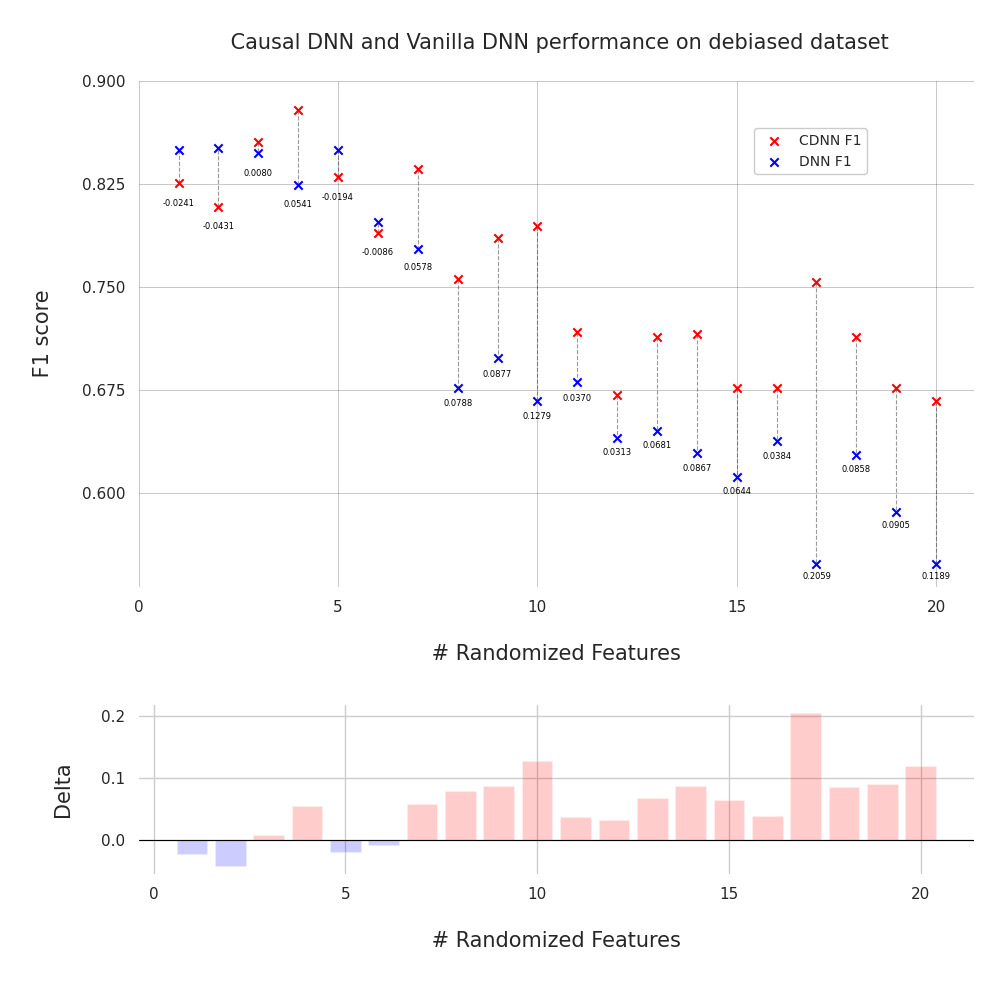

In [186]:
plt.figure(figsize=(10,12))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.scatter(x="Total shuffled", y="CDNN F1", data=final_scores, color='red', zorder=3, label='CDNN F1', marker='x')
ax1.scatter(x="Total shuffled", y="DNN F1", data=final_scores, color='blue', zorder=2, label='DNN F1', marker='x')

for i in range(len(final_scores)):
    
    x = final_scores["Total shuffled"].iloc[i]
    ycdnn = final_scores["CDNN F1"].iloc[i]
    ydnn = final_scores["DNN F1"].iloc[i]

    ax1.plot([x, x], [ycdnn, ydnn], '--', color='black', linewidth=.8, zorder=1, alpha=.4)  
    difference = ycdnn - ydnn
    ax1.text(x, min(ycdnn, ydnn) - min(ycdnn, ydnn) * 0.02, f'{difference:.4f}', fontsize=6, color='black', ha='center')

ax1.set_ylabel("\n F1 score \n", fontsize=15)
ax1.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax1.set_xticks(np.linspace(0, 20, num=5))
ax1.set_yticks(np.linspace(0.6, .9, num=5))

ax1.set_title("\n Causal DNN and Vanilla DNN performance on debiased dataset\n", fontsize=15)
ax1.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
ax1.legend(loc='upper right', fontsize=10, frameon=True, bbox_to_anchor=(0.88, 0.92), framealpha=1)

for spine in ax1.spines.values():
    spine.set_visible(False)

colors = np.where(final_scores['Delta F1'] <= 0, 'blue', 'red')
ax2.bar(final_scores["Total shuffled"], final_scores["Delta F1"], color=colors, alpha=.2)
ax2.set_ylabel("Delta\n", fontsize=15)
ax2.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(np.linspace(0, 20, num=5))

for spine in ax2.spines.values():
    spine.set_visible(False)

plt.draw()
plt.savefig('Figures/FIG21_TOP20_BENCHMARK_F1.jpeg', dpi=400, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()

<Figure size 1000x1200 with 0 Axes>

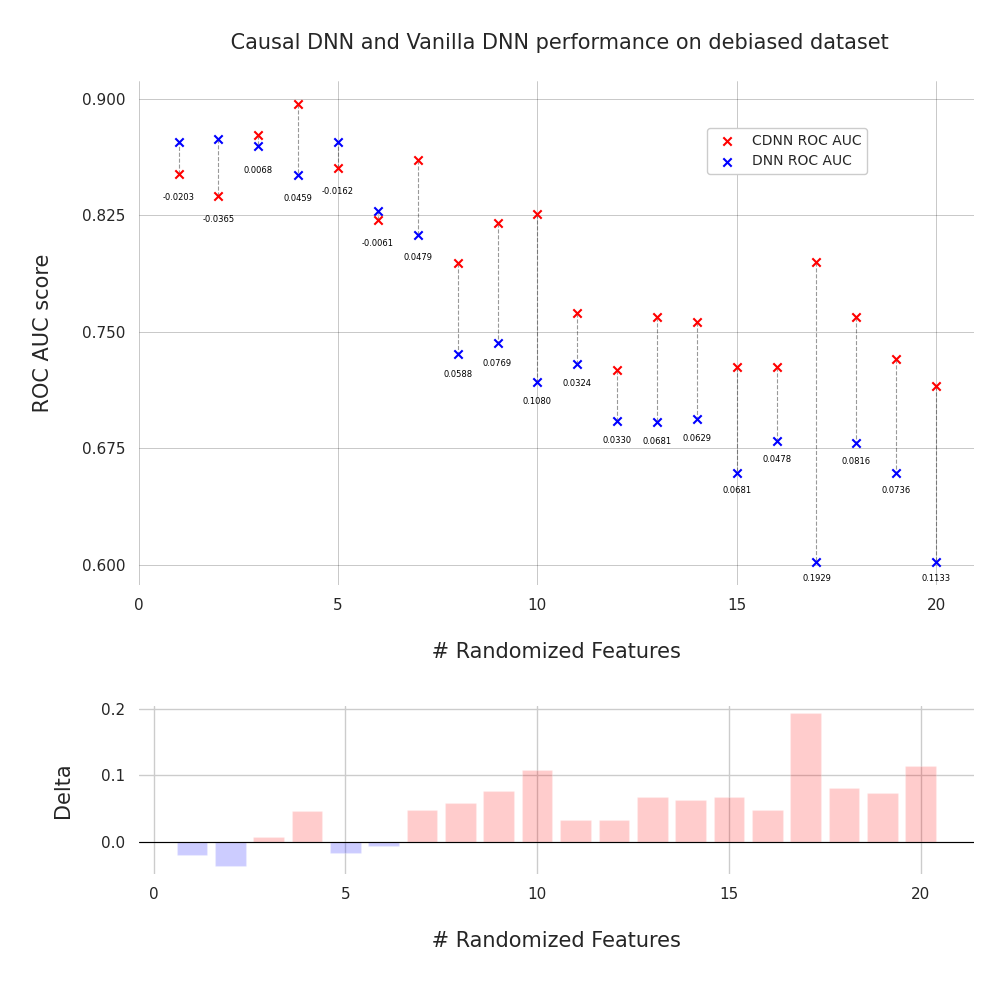

In [187]:
plt.figure(figsize=(10,12))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.scatter(x="Total shuffled", y="CDNN ROC AUC", data=final_scores, color='red', zorder=3, label='CDNN ROC AUC', marker='x')
ax1.scatter(x="Total shuffled", y="DNN ROC AUC", data=final_scores, color='blue', zorder=2, label='DNN ROC AUC', marker='x')

for i in range(len(final_scores)):
    
    x = final_scores["Total shuffled"].iloc[i]
    ycdnn = final_scores["CDNN ROC AUC"].iloc[i]
    ydnn = final_scores["DNN ROC AUC"].iloc[i]

    ax1.plot([x, x], [ycdnn, ydnn], '--', color='black', linewidth=.8, zorder=1, alpha=.4)  
    difference = ycdnn - ydnn
    ax1.text(x, min(ycdnn, ydnn) - min(ycdnn, ydnn) * 0.02, f'{difference:.4f}', fontsize=6, color='black', ha='center')

ax1.set_ylabel("\n ROC AUC score \n", fontsize=15)
ax1.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax1.set_xticks(np.linspace(0, 20, num=5))
ax1.set_yticks(np.linspace(0.6, .9, num=5))

ax1.set_title("\n Causal DNN and Vanilla DNN performance on debiased dataset\n", fontsize=15)
ax1.grid(color='black', linestyle='-', linewidth=.5, alpha=.3)
ax1.legend(loc='upper right', fontsize=10, frameon=True, bbox_to_anchor=(0.88, 0.92), framealpha=1)

for spine in ax1.spines.values():
    spine.set_visible(False)

colors = np.where(final_scores['Delta ROC AUC'] <= 0, 'blue', 'red')
ax2.bar(final_scores["Total shuffled"], final_scores["Delta ROC AUC"], color=colors, alpha=.2)
ax2.set_ylabel("Delta\n", fontsize=15)
ax2.set_xlabel("\n # Randomized Features \n", fontsize=15)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_xticks(np.linspace(0, 20, num=5))

for spine in ax2.spines.values():
    spine.set_visible(False)

plt.draw()
plt.savefig('Figures/FIG22_TOP20_BENCHMARK_ROCAUC.jpeg', dpi=400, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()